In [29]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

def readFile(filename):

    data = {"ch0": [], "ch1": [], "ch3": []}

    with open(filename) as file:

        # skip file header
        file.readline()
        file.readline()
        file.readline()
        file.readline()

        while True:

            # skip event header and check end of file
            if not file.readline(): break
            file.readline()

            # skip channel 0 header
            file.readline()

            ch0_vals = file.readline()
            ch0_vals = list(map(lambda x: -float(x), ch0_vals.split()))
            data["ch0"].append(np.array(ch0_vals))

            # skip channel 1 header
            file.readline()

            ch1_vals = file.readline()
            ch1_vals = list(map(lambda x: -float(x), ch1_vals.split()))
            data["ch1"].append(np.array(ch1_vals))

            # skip channel 2 header
            file.readline()

            ch3_vals = file.readline()
            ch3_vals = list(map(lambda x: -float(x), ch3_vals.split()))
            data["ch3"].append(np.array(ch3_vals))

    data["ch0"] = np.array(data["ch0"])
    data["ch1"] = np.array(data["ch1"])
    data["ch3"] = np.array(data["ch3"])

    return data

##  ################  ################  ################
##  Slow wave catcher
##  ################  ################  ################
data_slow = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_100 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_SLOW = 100
times_slow = np.arange(1024)*SAMPLE_RATE_SLOW

data_slow["times"] = times_slow
data_slow["sample_rate"] = SAMPLE_RATE_SLOW
data_slow["type"] = "slow"


##  ################  ################  ################
##  Fast wave catcher
##  ################  ################  ################
data_fast = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_2.5 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_FAST = 2.5
times_fast = np.arange(1024)*SAMPLE_RATE_FAST

data_fast["times"] = times_fast
data_fast["sample_rate"] = SAMPLE_RATE_FAST
data_fast["type"] = "fast"

In [30]:
def align_datasamples(data):

    # start index
    data["st_idx"] = np.empty(data["ch0"].shape[0], dtype=int)

    for i in range(data["ch0"].shape[0]):

        max_val = np.max(data["ch0"][i])

        start_idx = np.argmax(data["ch0"][i] >= 0.5*max_val)

        if data["type"] == "fast":
            # remove bad events. ch0 max value is about 0.8 for all good events.
            if np.max(data["ch0"][i]) < 0.6:
                start_idx = 0

        elif data["type"] == "slow":
            # sometimes we have two synchro peacks, the correct one is first and low in y scale
            # this if branch of code to account for that effect
            if start_idx > 100:
                
                start_idx = np.argmax(data["ch0"][i] >= 0.03)

        else:
            print("ERROR: unknown wave catcher type")

        data["st_idx"][i] = start_idx

    min_st_idx = int(np.min(data["st_idx"]))
    max_st_idx = int(np.max(data["st_idx"]))

    data["min_st_idx"] = min_st_idx
    data["max_st_idx"] = max_st_idx

    data_shifted = dict(data)
    data_shifted["ch0"] = np.empty([ data["ch0"].shape[0], data["ch0"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch1"] = np.empty([ data["ch1"].shape[0], data["ch1"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch3"] = np.empty([ data["ch3"].shape[0], data["ch3"].shape[1] - (max_st_idx-min_st_idx) ])


    for i in range(data["ch0"].shape[0]):

        stIdx = data["st_idx"][i]

        start_idx = stIdx-min_st_idx
        stop_ind  = data["ch0"][i].size -(max_st_idx-stIdx)

        data_shifted["ch0"][i] = data["ch0"][i, start_idx: stop_ind]
        data_shifted["ch1"][i] = data["ch1"][i, start_idx: stop_ind]
        data_shifted["ch3"][i] = data["ch3"][i, start_idx: stop_ind]

    data_shifted["times"] = data["times"][:-(max_st_idx-min_st_idx)]

    return data_shifted

data_fast_aligned = align_datasamples(data_fast)
data_slow_aligned = align_datasamples(data_slow)

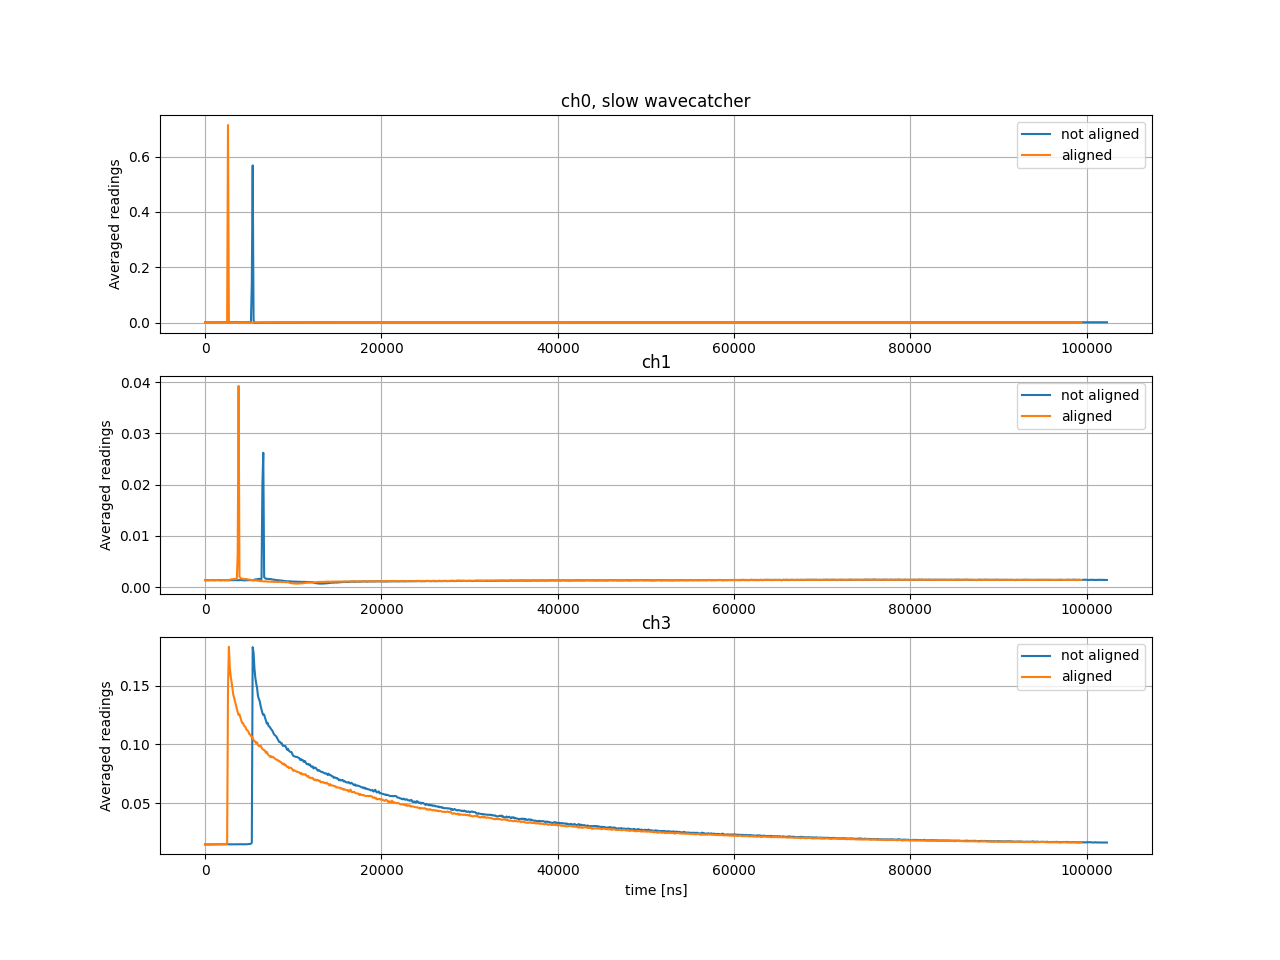

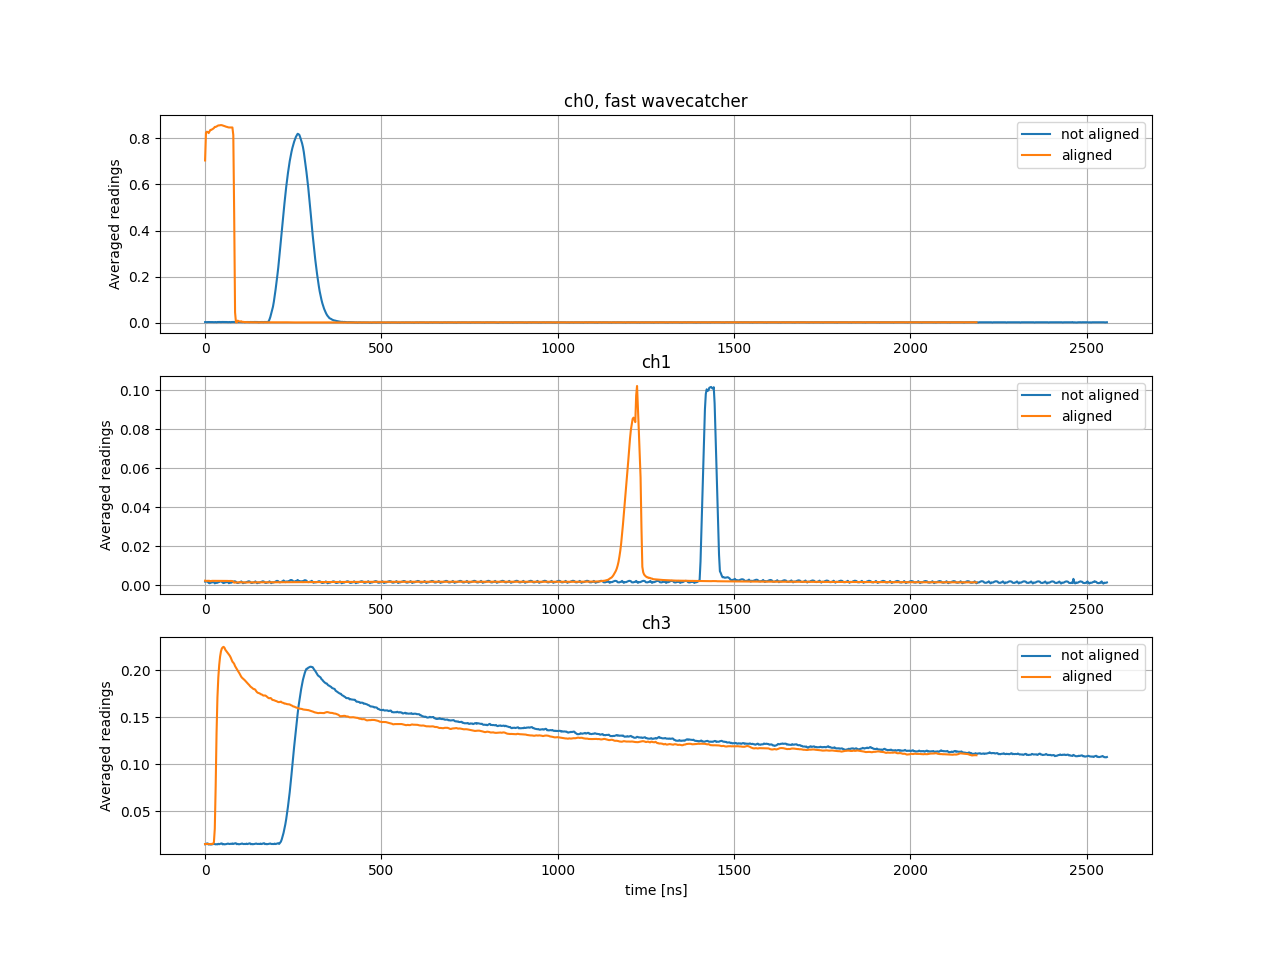

In [31]:
def visualise_aligning(data_raw, data_aligned):

    plt.figure(figsize=(6.4*2, 4.8*2))

    assert data_raw["type"] == data_aligned["type"]


    plt.subplot(3,1,1)
    plt.plot(data_raw["times"], np.mean(data_raw["ch0"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch0"], axis=0), label="aligned")
    plt.title(f"ch0, {data_raw['type']} wavecatcher")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.subplot(3,1,2)
    plt.plot(data_raw["times"], np.mean(data_raw["ch1"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch1"], axis=0), label="aligned")
    plt.title("ch1")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.subplot(3,1,3)
    plt.plot(data_raw["times"], np.mean(data_raw["ch3"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch3"], axis=0), label="aligned")
    plt.title("ch3")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.xlabel("time [ns]")



visualise_aligning(data_slow, data_slow_aligned)
visualise_aligning(data_fast, data_fast_aligned)

In [32]:
def calc_charge(data):

    if data["type"] == "fast":
        resistance = 50 # ohm
        st_idx = int(np.floor(22/data["sample_rate"]))
        md_idx = st_idx + int(np.floor(90/data["sample_rate"]))
        ed_idx = st_idx + int(np.floor(1200/data["sample_rate"]))
    elif data["type"] == "slow":
        resistance = 50 # ohm
        st_idx = int(np.floor(2500/data["sample_rate"]))
        md_idx = st_idx + int(np.floor(300/data["sample_rate"]))
        ed_idx = st_idx + int(np.floor(1200/data["sample_rate"]))        
    else:
        print("ERROR: unknown type of the wave catcher")


    data["Qc_arr"] = np.empty(data["ch3"].shape[0])
    data["Qs_arr"] = np.empty(data["ch3"].shape[0])

    data["baseline"] = np.empty(data["ch3"].shape[0])


    for i in range(data["ch3"].shape[0]):

        bkg = np.mean(data["ch3"][i, :st_idx])
        data["baseline"][i] = bkg

        Qc = (data["ch3"][i, st_idx:md_idx] - bkg)/resistance 
        Qc = np.sum(Qc)*data["sample_rate"]*1e-9
        data["Qc_arr"][i] = Qc

        Qs = (data["ch3"][i, md_idx:ed_idx] - bkg)/resistance
        Qs = np.sum(Qs)*data["sample_rate"]*1e-9
        data["Qs_arr"][i] = Qs
        
    # # plot histogram of charge Q = Qc_arr + Qs_arr
    # plt.figure(figsize=(6.4*2, 4.8))
    # plt.hist(data["Qc_arr"]+data["Qs_arr"], bins=30)
    # plt.title(f"Charge integrated over 1.2 mks, {data['type']} wavecatcher.")
    # plt.xlabel("Q [C]")
    # plt.grid()


calc_charge(data_slow_aligned)
calc_charge(data_fast_aligned)

In [33]:
from enum import Enum, auto

class EvtType(Enum):
    Cherencov = auto()
    ZeroQc = auto()
    BadBaseline = auto()
    Good = auto()


def decide_event_acceptance(data):

    evtTypes = np.ones_like(data["Qs_arr"])*EvtType.Good.value

    if data["type"] == "fast":

        discrimination_curve = lambda x: 2.5*(x-0.05)   
        data["discrimination_curve"] = discrimination_curve      

        badBaseThresh = 0.0165

        ZeroQcTresh = 0.004 # nC

    elif data["type"] == "slow":

        discrimination_curve = lambda x: 0.50*(x-0.05)     
        data["discrimination_curve"] = discrimination_curve     

        badBaseThresh = 0.0165

        ZeroQcTresh = 0.02 # nC

    else:

        print("ERROR: unknown type of the wave catcher")


    # Removing cherencov events
    rejectedCherenkov = (data["Qs_arr"]/1e-9 < discrimination_curve(data["Qc_arr"]/1e-9))
    evtTypes[rejectedCherenkov] = EvtType.Cherencov.value
    
    # Removing zero Qc events
    rejectZeroQc = data["Qc_arr"]/1e-9 < ZeroQcTresh
    evtTypes[rejectZeroQc] = EvtType.ZeroQc.value

    # Removing bad baseline
    rejectBaseline = data["baseline"] > badBaseThresh
    evtTypes[rejectBaseline] = EvtType.BadBaseline.value

    data["evtTypes"] = evtTypes


decide_event_acceptance(data_slow_aligned)
decide_event_acceptance(data_fast_aligned)   

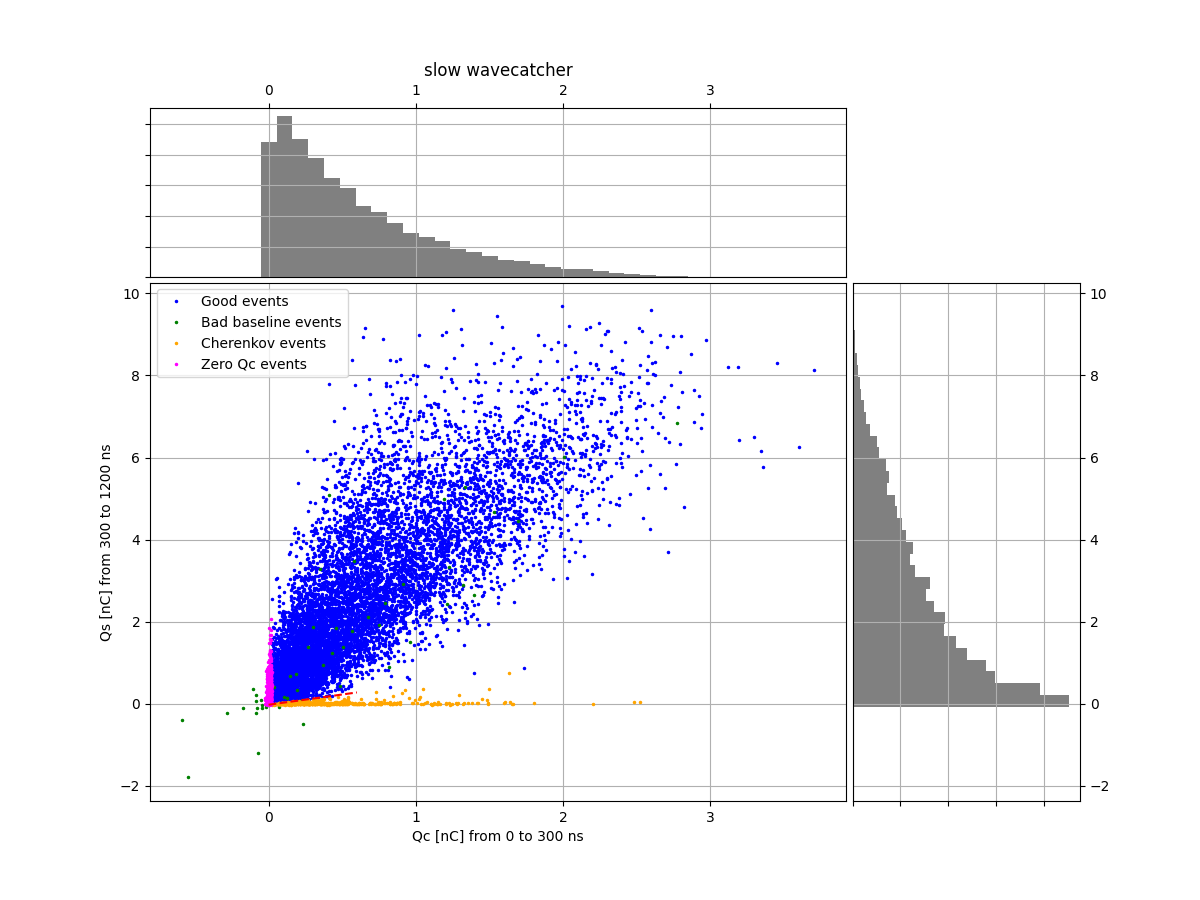

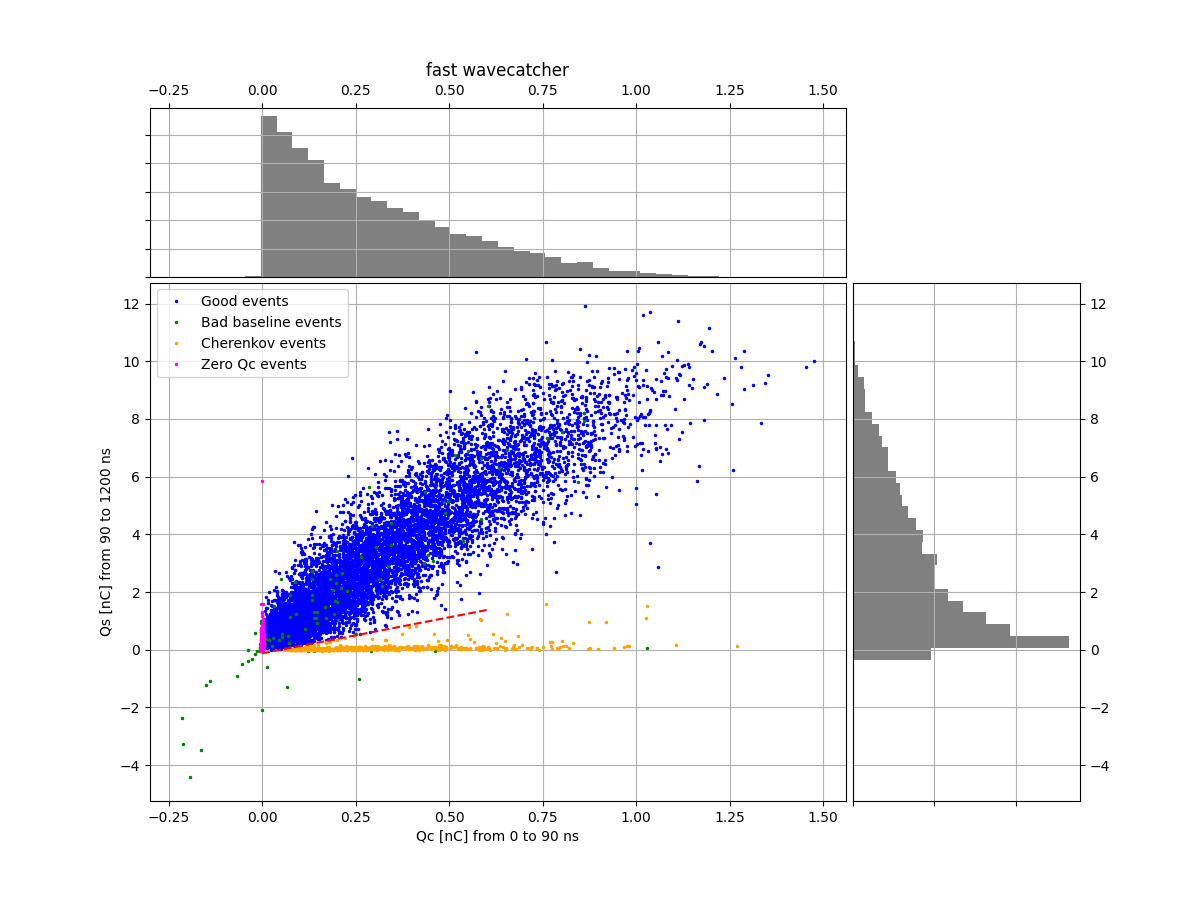

In [34]:
def visualise_charges(data):

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(12, 9))
    grid = plt.GridSpec(4, 4, hspace=0.03, wspace=0.03)
    main_ax = fig.add_subplot(grid[1:, :-1])
    y_hist = fig.add_subplot(grid[1:, -1], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[0, :-1], yticklabels=[], sharex=main_ax)
    
    # scatter points on the main axes
    main_ax.plot(data["Qc_arr"][data["evtTypes"] == EvtType.Good.value]/1e-9, data["Qs_arr"][data["evtTypes"] == EvtType.Good.value]/1e-9, ".", color="blue", markersize=3, label="Good events")
    main_ax.plot(data["Qc_arr"][data["evtTypes"] == EvtType.BadBaseline.value]/1e-9, data["Qs_arr"][data["evtTypes"] == EvtType.BadBaseline.value]/1e-9, ".", color="green", markersize=3, label="Bad baseline events")
    main_ax.plot(data["Qc_arr"][data["evtTypes"] == EvtType.Cherencov.value]/1e-9, data["Qs_arr"][data["evtTypes"] == EvtType.Cherencov.value]/1e-9, ".", color="orange", markersize=3, label="Cherenkov events")
    main_ax.plot(data["Qc_arr"][data["evtTypes"] == EvtType.ZeroQc.value]/1e-9, data["Qs_arr"][data["evtTypes"] == EvtType.ZeroQc.value]/1e-9, ".", color="magenta", markersize=3, label="Zero Qc events")


    if data["type"] == "fast":
        main_ax.set_xlabel("Qc [nC] from 0 to 90 ns")
        main_ax.set_ylabel("Qs [nC] from 90 to 1200 ns")   
    elif data["type"] == "slow":
        main_ax.set_xlabel("Qc [nC] from 0 to 300 ns")
        main_ax.set_ylabel("Qs [nC] from 300 to 1200 ns")           
    else:
        print("ERROR: unknown type of the wave catcher")

    main_ax.grid()
    main_ax.legend()


    # histogram on the attached axes
    x_hist.hist(data["Qc_arr"]/1e-9, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
    x_hist.xaxis.set_label_position('top')
    x_hist.xaxis.tick_top()
    x_hist.grid()
    x_hist.set_title(f"{data['type']} wavecatcher")


    y_hist.hist(data["Qs_arr"]/1e-9, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
    y_hist.yaxis.set_label_position('right')
    y_hist.yaxis.tick_right()
    y_hist.grid()

    
    disc_x_c = np.array([0, 0.6])
    disc_y_c = data['discrimination_curve'](disc_x_c)
    main_ax.plot(disc_x_c, disc_y_c, "--r")    

visualise_charges(data_slow_aligned)
visualise_charges(data_fast_aligned)

## Plot every event type

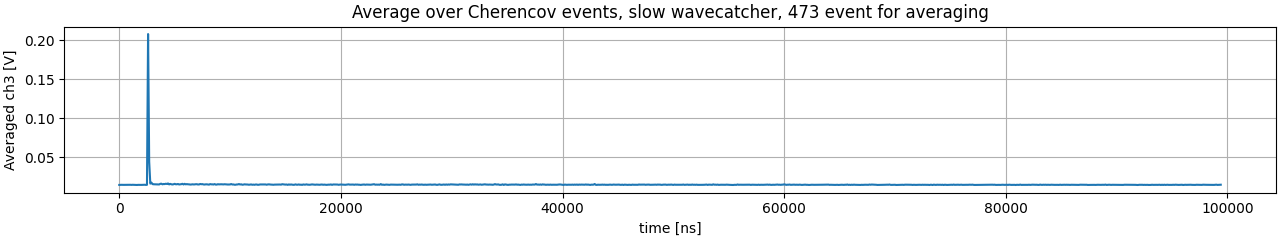

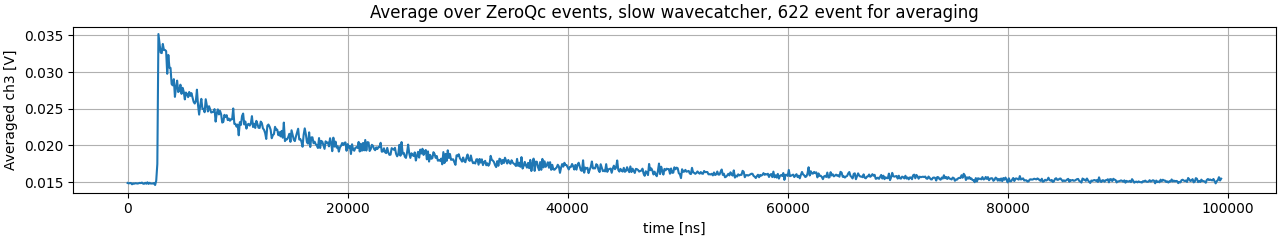

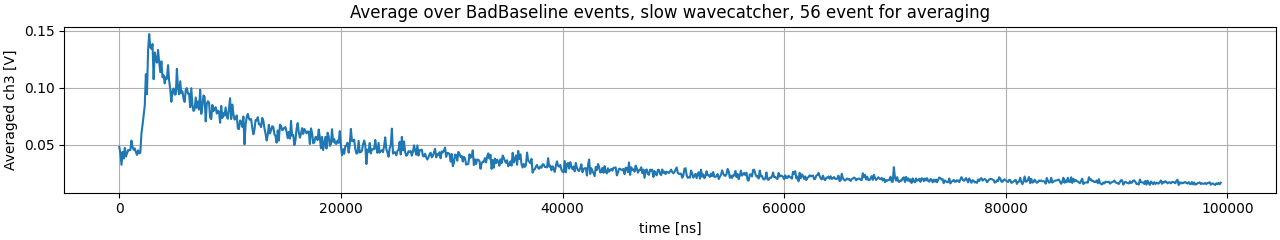

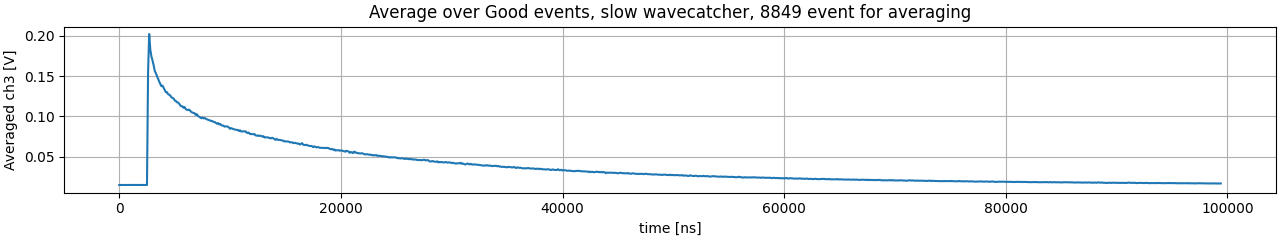

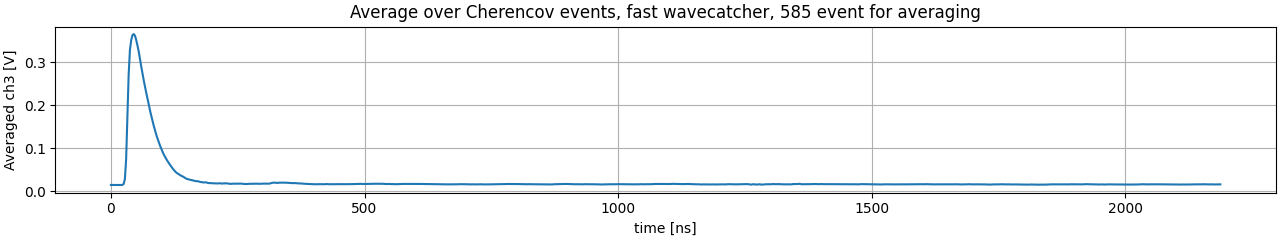

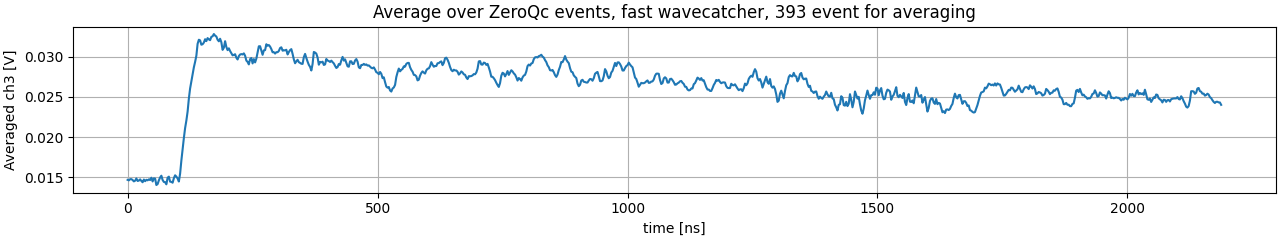

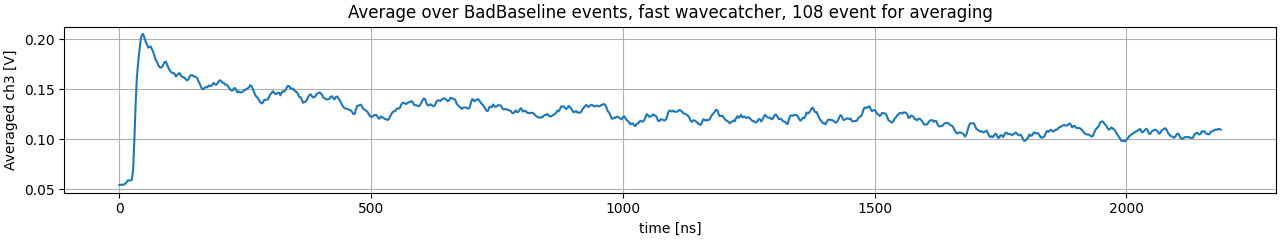

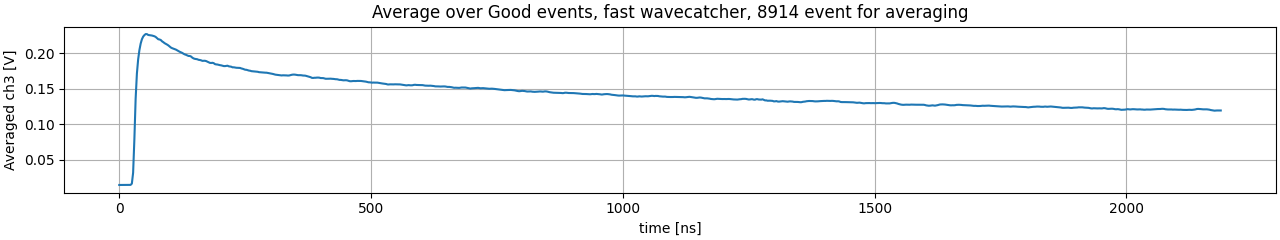

In [35]:
def plotEventType(data):

    for evtTypes in EvtType:

        current_events = data["ch3"][data["evtTypes"] == evtTypes.value]

        plt.figure(figsize=(6.4*2, 4.8/2), constrained_layout=True)
        plt.plot(data["times"], np.mean(current_events, axis=0))
        plt.ylabel("Averaged ch3 [V]")
        plt.xlabel("time [ns]")
        plt.title(f"Average over {evtTypes.name} events, {data['type']} wavecatcher, {current_events.shape[0]} event for averaging")
        plt.grid()        

plotEventType(data_slow_aligned)
plotEventType(data_fast_aligned)

## Aligning zero time of averaged curve

In [36]:
def get_t0_aligned_t_and_V(data):

    data["ch3_average"] = np.mean(data["ch3"][data["evtTypes"] == EvtType.Good.value], axis=0)

    max_V = np.max(data["ch3_average"])

    t0_idx = np.argmax(data["ch3_average"] > 0.5*max_V)
    
    zero_baseline = np.mean( data["ch3_average"][:int(t0_idx/2)])

    return data["times"]-t0_idx*data["sample_rate"], data["ch3_average"]-zero_baseline

data_fast_aligned["times_t0"], data_fast_aligned["ch3_average_t0"] = get_t0_aligned_t_and_V(data_fast_aligned)
data_slow_aligned["times_t0"], data_slow_aligned["ch3_average_t0"] = get_t0_aligned_t_and_V(data_slow_aligned)

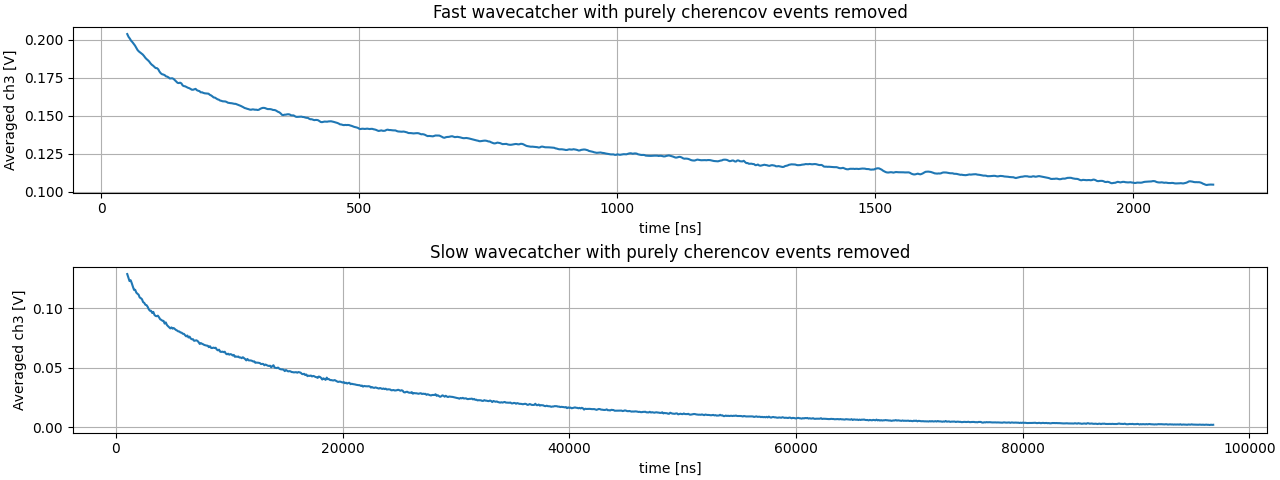

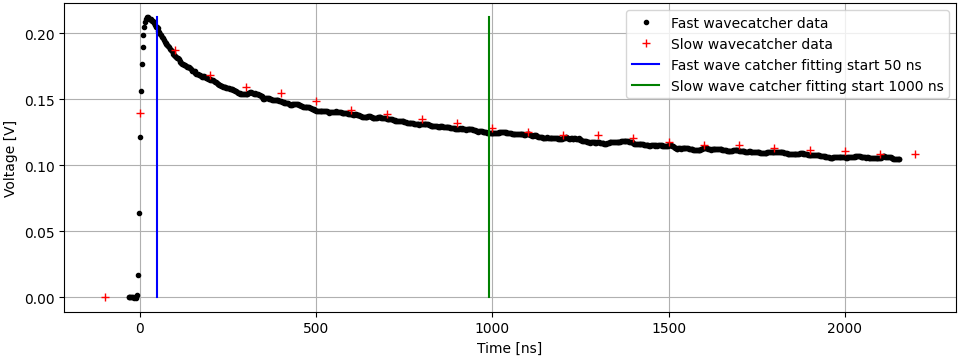

In [37]:
# F_ST_FIT_IDX = 0
# S_ST_FIT_IDX = 0

F_ST_FIT_TIM = 50   # ns
# F_ST_FIT_TIM = 75   # ns
# S_ST_FIT_TIM = 5000 # ns
S_ST_FIT_TIM = 1000 # ns

F_ST_FIT_IDX = np.argmax(data_fast_aligned["times_t0"] >= F_ST_FIT_TIM)
S_ST_FIT_IDX = np.argmax(data_slow_aligned["times_t0"] >= S_ST_FIT_TIM)

plt.figure(figsize=(6.4*2, 4.8), constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(data_fast_aligned["times_t0"][F_ST_FIT_IDX:], data_fast_aligned["ch3_average_t0"][F_ST_FIT_IDX:])
plt.ylabel("Averaged ch3 [V]")
plt.xlabel("time [ns]")
plt.title("Fast wavecatcher with purely cherencov events removed")
plt.grid()


plt.subplot(2,1,2)
plt.plot(data_slow_aligned["times_t0"][S_ST_FIT_IDX:], data_slow_aligned["ch3_average_t0"][S_ST_FIT_IDX:])
plt.ylabel("Averaged ch3 [V]")
plt.xlabel("time [ns]")
plt.title("Slow wavecatcher with purely cherencov events removed")
plt.grid()



plt.figure(figsize=(6.4*1.5, 4.8*0.75), constrained_layout=True)
plt.plot(data_fast_aligned["times_t0"], data_fast_aligned["ch3_average_t0"], ".k", label="Fast wavecatcher data")
plt.plot(data_slow_aligned["times_t0"][25:49], data_slow_aligned["ch3_average_t0"][25:49], "+r", label="Slow wavecatcher data")

max_V = np.max(data_fast_aligned["ch3_average_t0"])

plt.plot([F_ST_FIT_TIM-0.1*SAMPLE_RATE_FAST, F_ST_FIT_TIM-0.1*SAMPLE_RATE_FAST], [0, max_V], "-b", label = f"Fast wave catcher fitting start {F_ST_FIT_TIM} ns")
plt.plot([S_ST_FIT_TIM-0.1*SAMPLE_RATE_SLOW, S_ST_FIT_TIM-0.1*SAMPLE_RATE_SLOW], [0, max_V], "-g", label = f"Slow wave catcher fitting start {S_ST_FIT_TIM} ns")

plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.grid()



In [38]:
import uproot

def get_hist_2_fit(data):

    counts = data["ch3_average_t0"]

    t_st = data["times_t0"][ 0] - data["sample_rate"]/2
    t_ed = data["times_t0"][-1] + data["sample_rate"]/2
    num_bins = data["times_t0"].size
    edges = np.linspace(t_st, t_ed, num_bins+1)/1000

    return (counts, edges)

file = uproot.recreate("example.root")

file["hist_fast"] = get_hist_2_fit(data_fast_aligned)
file["hist_slow"] = get_hist_2_fit(data_slow_aligned)

file.close()

In [39]:
# from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

f_tim_fit = data_fast_aligned["times_t0"][F_ST_FIT_IDX:]
f_dat_fit = data_fast_aligned["ch3_average_t0"][F_ST_FIT_IDX:]

s_tim_fit = data_slow_aligned["times_t0"][S_ST_FIT_IDX:]
s_dat_fit = data_slow_aligned["ch3_average_t0"][S_ST_FIT_IDX:]

FIT_TYPE = "MSE"
# FIT_TYPE = "CHI2n"

def objective(argument):

    C, A1, A2, A3, A4, L1, L2, L3, L4 = argument

    tf = f_tim_fit
    ts = s_tim_fit

    f_pred =    A1*np.exp(-L1*(tf)) + A2*np.exp(-L2*(tf)) + A3*np.exp(-L3*(tf)) + A4*np.exp(-L4*(tf)) 
    s_pred = C*(A1*np.exp(-L1*(ts)) + A2*np.exp(-L2*(ts)) + A3*np.exp(-L3*(ts)) + A4*np.exp(-L4*(ts)))

    if FIT_TYPE == "CHI2n":
        f_loss = np.sqrt(np.sum((f_pred-f_dat_fit)**2/f_dat_fit)/f_dat_fit.size)
        s_loss = np.sqrt(np.sum((s_pred-s_dat_fit)**2/s_dat_fit)/s_dat_fit.size)
    elif FIT_TYPE == "MSE":
        f_loss = np.sqrt(np.sum((f_pred-f_dat_fit)**2)/f_dat_fit.size)
        s_loss = np.sqrt(np.sum((s_pred-s_dat_fit)**2)/s_dat_fit.size)
    else:
        raise Exception("Unknown type of fit")


    return f_loss + s_loss*1.1


def get_fit_params():

    # C  = 1
    # A1 = 0.06774668270872275
    # A2 = 0.03969431720392941
    # A3 = 0.05459894875795671
    # A4 = 0.06828783534109807
    # L1  = 1/25900.0
    # L2  = 1/7500.00
    # L3  = 1/700.000
    # L4  = 1/70.0000   

    
    # # Another good results with slow redings starting gtom 2 mus
    # C = 0.9980996047728232
    # A1 = 0.07228202832433435
    # A2 = 0.04680483155184595
    # A3 = 0.04662590654689548
    # A4 = 0.051448656362562066
    # L1 = 1/25980.69697509159
    # L2 = 1/5485.152769478868
    # L3 = 1/730.9154493139208
    # L4 = 1/90.68931484771362

    C = 0.9883301606757705
    A1 = 0.07194201676120071
    A2 = 0.041863495704632665
    A3 = 0.048951096880570345
    A4 = 0.05374333820852844
    L1 = 3.849335854457291e-05
    L2 = 0.0001538420658393388
    L3 = 0.0011494065889385645
    L4 = 0.010206385836218515


    pars = [C, A1, A2, A3, A4, L1, L2, L3, L4]

    bounds = [
        ( C   *0.4,  C   *1.6),  # C 
        ( A1  *0.4,  A1  *1.6),  # A1
        ( A2  *0.4,  A2  *1.6),  # A2
        ( A3  *0.4,  A3  *1.6),  # A3
        ( A4  *0.4,  A4  *1.6),  # A4
        ( L1  *0.4,  L1  *1.6),  # L1
        ( L2  *0.4,  L2  *1.6),  # L2
        ( L3  *0.4,  L3  *1.6),  # L3
        ( L4  *0.4,  L4  *1.6),  # L4
    ]


    # minim_results = minimize(objective, x0=pars, bounds=bounds)

    minim_results = dual_annealing(objective, 
                                   bounds, 
                                   x0 = pars,
                                   maxiter=20000,            # More iterations → better chance to find global min
                                   initial_temp=9230.0,      # Higher starting temperature → broader search
                                   restart_temp_ratio=2e-5,  # Lower value → longer before restarting
                                   visit=10.62,              # Controls exploration of space
                                   accept=-50.0,             # Controls acceptance of worse solutions
                                   no_local_search=False,    # Enables local search after annealing phase
                                   ) 
    minim_results = minimize(objective, x0=minim_results.x, bounds=bounds)

    # minim_results = dual_annealing(objective, bounds, x0 = pars) 

    C, A1, A2, A3, A4, L1, L2, L3, L4 = minim_results.x

    result = {
        "C"  : C ,
        "A1" : A1,
        "A2" : A2,
        "A3" : A3,
        "A4" : A4,
        "L1" : L1,
        "L2" : L2,
        "L3" : L3,
        "L4" : L4
        }
    
    return result

## First fit of the fast wavecatcher

In [42]:
def fitFunc(t, C, A1, A2, A3, A4, L1, L2, L3, L4):

    return C*(A1*np.exp(-L1*(t)) + A2*np.exp(-L2*(t)) + A3*np.exp(-L3*(t)) + A4*np.exp(-L4*(t)))


# Fitting

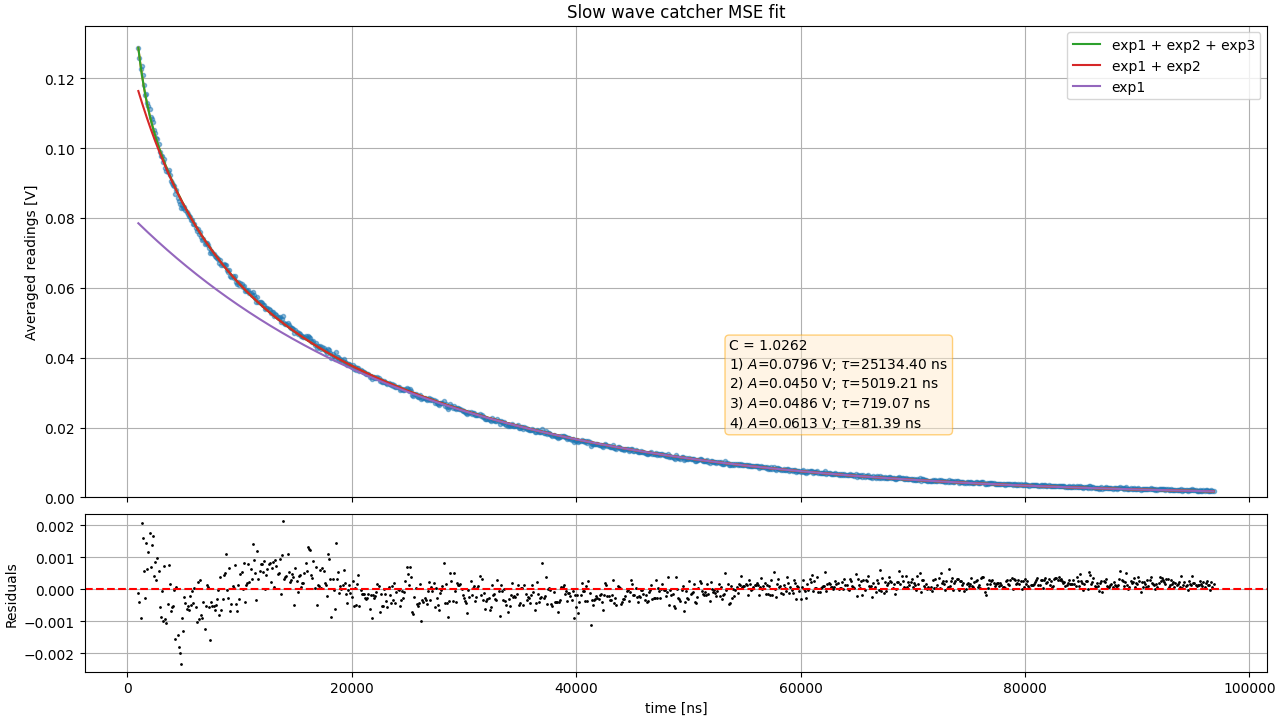

In [43]:
fig, (axm, axe) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6.4*2,4.8*1.5), constrained_layout=True)


#############################################
## Perform fitting and draw it on the plot ##
#############################################

times_plot = np.linspace(np.min(s_tim_fit), np.max(s_tim_fit), int((np.max(s_tim_fit) - np.min(s_tim_fit))/data_fast["sample_rate"]))

fit_params = get_fit_params()

axm.plot(s_tim_fit, s_dat_fit, ".", alpha = 0.5)

C, A1, A2, A3, A4, L1, L2, L3, L4 = fit_params.values()

axm.plot(times_plot, fitFunc(times_plot, C, A1, A2, A3, A4, L1, L2, L3, L4))

exp123 = lambda t: C*(A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t))
axm.plot(times_plot, exp123(times_plot), label="exp1 + exp2 + exp3")

exp12 = lambda t: C*(A1*np.exp(-L1*t) + A2*np.exp(-L2*t))
axm.plot(times_plot, exp12(times_plot), label="exp1 + exp2")

exp1 = lambda t: C*A1*np.exp(-L1*t)
axm.plot(times_plot, exp1(times_plot), label="exp1")

axm.set_ylabel("Averaged readings [V]")
axm.set_ylim(0, None)
axm.grid()
axm.legend()
axm.set_title(f"Slow wave catcher {FIT_TYPE} fit")


bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
axm.text( 0.545, 0.15,
         "C = {:.5}\n".format(fit_params["C"])+\
         "1) $A$={:.4f} V; $\\tau$={:.2f} ns\n".format(fit_params["A1"], 1/fit_params["L1"])+\
         "2) $A$={:.4f} V; $\\tau$={:.2f} ns\n".format(fit_params["A2"], 1/fit_params["L2"])+\
         "3) $A$={:.4f} V; $\\tau$={:.2f} ns\n".format(fit_params["A3"], 1/fit_params["L3"])+\
         "4) $A$={:.4f} V; $\\tau$={:.2f} ns  ".format(fit_params["A4"], 1/fit_params["L4"]),      
         transform = axm.transAxes, bbox=bbox)


#########################################################
## Perform estimation and draw of the uncertainty bars ##
#########################################################

# # Compute uncertainty in fit
# num_samples = 10000  # Number of Monte Carlo samples for uncertainty estimation
# param_samples = np.random.multivariate_normal(list(fit_params.values()), pconv, size=num_samples)

# y_fits = np.array([fitFunc(times_merged, *p) for p in param_samples])
# y_fit_mean = np.mean(y_fits, axis=0)
# y_fit_std = np.std(y_fits, axis=0)

residuals = s_dat_fit - fitFunc(s_tim_fit, C, A1, A2, A3, A4, L1, L2, L3, L4)

# Plot the residuals with error bars
axe.plot(s_tim_fit, residuals, ".k", markersize=2)
axe.axhline(0, color="red", linestyle="--")
# axe.fill_between(times_merged, -2 * y_fit_std, 2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

# axm.fill_between(times_merged, y_fit_mean-2 * y_fit_std, y_fit_mean+2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

axe.set_ylabel("Residuals")
axe.set_xlabel("time [ns]")
# axe.legend()
axe.grid()


In [44]:
for key, value in fit_params.items():

    print(key,"=", value)

print("\n ============================ \n")

print("tau1 =", 1/fit_params["L1"] )
print("tau2 =", 1/fit_params["L2"] )
print("tau3 =", 1/fit_params["L3"] )
print("tau4 =", 1/fit_params["L4"] )

print("\n ============================ \n")

print("Loss function", objective(fit_params.values()))

C = 1.0262386264955032
A1 = 0.07957550990689241
A2 = 0.04501701148875398
A3 = 0.04855576304826064
A4 = 0.061295770416890535
L1 = 3.978611040091048e-05
L2 = 0.00019923444078300464
L3 = 0.0013906782090447633
L4 = 0.012286593460601071


tau1 = 25134.399666701665
tau2 = 5019.212522041537
tau3 = 719.073609909287
tau4 = 81.38952454206775


Loss function 0.00111945216342078


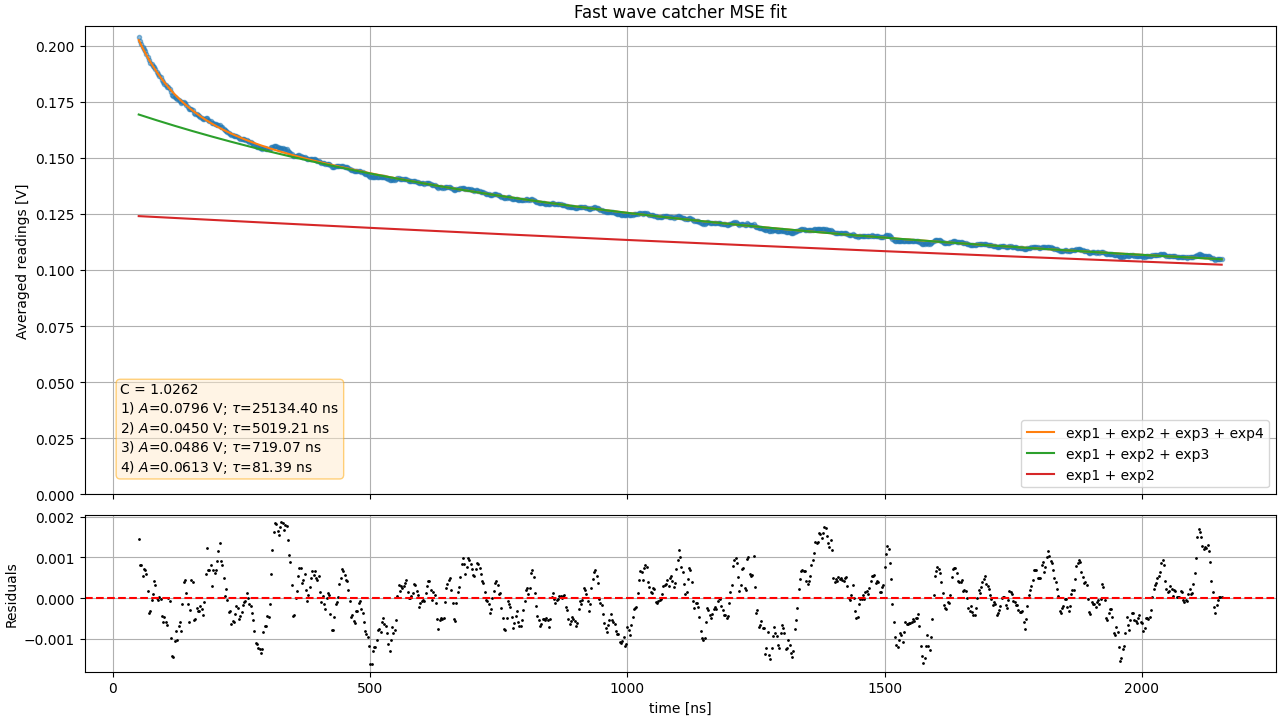

In [45]:
fig,(axm, axe) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6.4*2,4.8*1.5), constrained_layout=True)

times_fast = f_tim_fit
ch3_fast = f_dat_fit

#############################################
## Perform fitting and draw it on the plot ##
#############################################

times_plot = np.linspace(np.min(times_fast), np.max(times_fast), int((np.max(times_fast) - np.min(times_fast))/data_fast["sample_rate"]))



axm.plot(times_fast, ch3_fast, ".", alpha = 0.5)


axm.plot(times_plot, fitFunc(times_plot, 1, A1, A2, A3, A4, L1, L2, L3, L4), label = "exp1 + exp2 + exp3 + exp4")


exp123 = lambda t: A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t)
axm.plot(times_plot, exp123(times_plot), label="exp1 + exp2 + exp3")

exp12 = lambda t: A1*np.exp(-L1*t) + A2*np.exp(-L2*t)
axm.plot(times_plot, exp12(times_plot), label="exp1 + exp2")

# exp1 = lambda t: A1*np.exp(-L1*t)
# axm.plot(times_plot, exp1(times_plot))


axm.set_ylabel("Averaged readings [V]")
axm.set_ylim(0, None)
axm.grid()
axm.legend(loc = "lower right")
axm.set_title(f"Fast wave catcher {FIT_TYPE} fit")


bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
axm.text( 0.03, 0.05,
         "C = {:.5}\n".format(fit_params["C"])+\
         "1) $A$={:.4f} V; $\\tau$={:.2f} ns\n".format(fit_params["A1"], 1/fit_params["L1"])+\
         "2) $A$={:.4f} V; $\\tau$={:.2f} ns\n".format(fit_params["A2"], 1/fit_params["L2"])+\
         "3) $A$={:.4f} V; $\\tau$={:.2f} ns\n".format(fit_params["A3"], 1/fit_params["L3"])+\
         "4) $A$={:.4f} V; $\\tau$={:.2f} ns  ".format(fit_params["A4"], 1/fit_params["L4"]),      
         transform = axm.transAxes, bbox=bbox)


#########################################################
## Perform estimation and draw of the uncertainty bars ##
#########################################################

# # Compute uncertainty in fit
# num_samples = 10000  # Number of Monte Carlo samples for uncertainty estimation
# param_samples = np.random.multivariate_normal(list(fit_params.values()), pconv, size=num_samples)

# y_fits = np.array([fitFunc(times_fast, *p) for p in param_samples])
# y_fit_mean = np.mean(y_fits, axis=0)
# y_fit_std = np.std(y_fits, axis=0)

residuals = ch3_fast - fitFunc(times_fast, 1, A1, A2, A3, A4, L1, L2, L3, L4)


# Plot the residuals with error bars
axe.plot(times_fast, residuals, ".k", markersize=2)
axe.axhline(0, color="red", linestyle="--")
# axe.fill_between(times_fast, -2 * y_fit_std, 2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

# axm.fill_between(times_fast, y_fit_mean-2 * y_fit_std, y_fit_mean+2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

axe.set_ylabel("Residuals")
axe.set_xlabel("time [ns]")
# axe.legend()
axe.grid()